In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score, accuracy_score, f1_score
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import MDS

In [2]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] ='Malgun Gothic'

matplotlib.rcParams['axes.unicode_minus'] =False

In [3]:
weight=pd.read_csv('9000a 09520 - weight.csv')
weight

Unnamed: 0                  TimeStamp  Injection_Time  Filling_Time  \
0               0  2022-05-30 10:10:47+09:00            7.66          3.66   
1               1  2022-05-30 10:10:47+09:00            7.66          3.66   
2               2  2022-05-30 10:10:47+09:00            7.66          3.66   
3               3  2022-05-30 10:10:47+09:00            7.66          3.66   
4               4  2022-05-30 10:10:47+09:00            7.66          3.66   
...           ...                        ...             ...           ...   
53348      107011  2023-01-30 15:31:41+09:00            7.36          1.86   
53349      107012  2023-01-30 15:32:35+09:00            7.36          1.86   
53350      107013  2023-01-30 15:33:29+09:00            7.38          1.88   
53351      107014  2023-01-30 15:34:23+09:00            7.36          1.86   
53352      107015  2023-01-30 15:35:17+09:00            7.38          1.88   

       Plasticizing_Time  Cycle_Time  Clamp_Close_Time  Cushion_Position  \
0              25.150000   66.099998              4.57              21.6   
1              25.129999   66.099998              4.57              21.6   
2              25.180000   66.099998              4.57              21.5   
3              25.160000   66.099998              4.58              21.6   
4              25.160000   66.099998              4.56              21.6   
...                  ...         ...               ...               ...   
53348          11.590000   54.099998              4.44              15.0   
53349          11.570000   54.099998              4.44              15.0   
53350          11.570000   54.099998              4.44              15.1   
53351          11.570000   54.099998              4.44              15.1   
53352          11.580000   54.099998              4.44              15.0   

       Switch_Over_Position  Plasticizing_Position  ...  Hopper_PV  Hopper_SV  \
0                      23.0             158.199997  ...       80.0       80.0   
1                      23.0             158.100006  ...       80.0       80.0   
2                      22.9             158.199997  ...       80.0       80.0   
3                      23.0             158.199997  ...       80.0       80.0   
4                      23.0             158.199997  ...       80.0       80.0   
...                     ...                    ...  ...        ...        ...   
53348                  16.0              84.699997  ...       80.0       80.0   
53349                  16.0              84.800003  ...       80.0       80.0   
53350                  16.0              84.699997  ...       80.0       80.0   
53351                  16.0              84.699997  ...       80.0       80.0   
53352                  16.0              84.599998  ...       80.0       80.0   

       Product_CNT  Robot_Alarm  TakeOut_Time  TempCon_PV  TempCon_SV  Weight  \
0           1334.0         3333         11.95        50.0        50.0  1250.0   
1           1334.0         3333         11.95        50.0        50.0  1250.0   
2           1334.0         3333         11.95        50.0        50.0  1250.0   
3           1334.0         3333         11.95        50.0        50.0  1250.0   
4           1334.0         3333         11.95        50.0        50.0  1250.0   
...            ...          ...           ...         ...         ...     ...   
53348      27345.0         2222          7.79        61.9        62.0     1.0   
53349      27345.0         2222          7.79        61.9        62.0     1.0   
53350      27345.0         2222          7.79        61.9        62.0     1.0   
53351      27345.0         2222          7.79        61.9        62.0     1.0   
53352      27345.0         2222          7.79        61.9        62.0     1.0   

       Weight_Status  Workcd  
0               1111    HO25  
1               1111    HO25  
2               1111    HO25  
3               1111    HO25  
4               1111    HO25  
...              ...     

In [4]:
weight.drop(columns=['Unnamed: 0'], inplace=True)

<AxesSubplot:ylabel='Density'>

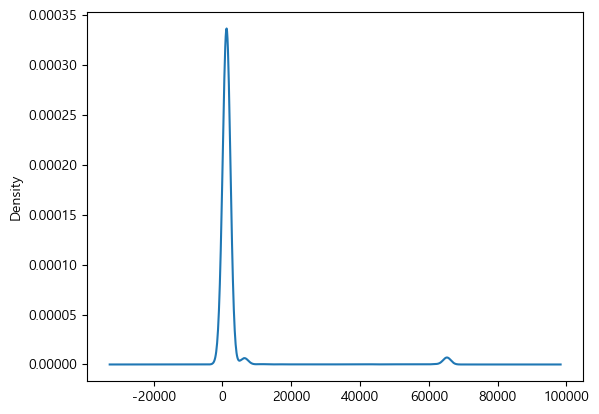

In [5]:
weight['Weight'].plot(kind='density')

In [6]:
from scipy.stats import kstest, normaltest, shapiro, anderson

# box plot 을 통해 outlier 확인하기 위함
def boxplot_whiskers(x):
    plt.figure()
    boxplot = plt.boxplot(x)
    boxplot_whiskers = [item.get_ydata() for item in boxplot['whiskers']]
    return(boxplot_whiskers)

def outlier_check(x):
    y = boxplot_whiskers(x)
    print(np.min(y), np.max(y))
    sigma_3_p = np.mean(x) + 3*np.std(x) 
    sigma_3_m = np.mean(x) - 3*np.std(x)
    print('3 sigma range :',sigma_3_m, sigma_3_p)
    out_idx = np.where(x>=sigma_3_p)[0]
    out_values = x[out_idx]
    plt.figure()
    boxplot = plt.boxplot(x[-out_idx])
    return(pd.DataFrame({'outlier_index': out_idx,'outliers': out_values}))


In [7]:
def Significance_Test(df_in):
    
    test_stat, p_val = shapiro(df_in)
    ks_stat, p_valks = kstest(df_in, 'norm')
    nm_stat, p_valnm = normaltest(df_in)

    print("SHAPIRO Result : test-statistics : {}, p-value : {}".format(test_stat, p_val))
    print("KS Result : test-statistics : {}, p-value : {}".format(ks_stat, p_valks))
    print("Normal Result : test-statistics : {}, p-value : {}".format(nm_stat, p_valnm))

    test_res1 = anderson(df_in, dist = 'norm')
    print(test_res1)

In [8]:
def statistic_anomaly_detection(df_in, process, upper_sig=2, under_sig=3):
    mean = df_in[process].mean()
    std = df_in[process].std()
    test_des = df_in[(df_in[process] < (mean+(3*std))) & (df_in[process] > (mean-(3*std)))][process].describe()
    display(test_des)
    print()
    print()
    print('mean ', test_des['mean'])

    usl, lsl = test_des['mean'] + (upper_sig*test_des['std']), test_des['mean'] - (under_sig*test_des['std'])

    print(f"usl: {usl}, lsl: {lsl}")

    print()
    print()
    test_df_c = df_in.copy()


    anomal_upper = test_df_c[test_df_c[process]>= usl].index
    anomal_under = test_df_c[test_df_c[process]<= lsl].index
    test_df_c['anomal_detection'] = 0
    test_df_c.loc[anomal_upper, 'anomal_detection'] = 1
    test_df_c.loc[anomal_under, 'anomal_detection'] = 1
    test_df_c.reset_index(drop=True, inplace=True)
    display(test_df_c)

    print()
    print()

    mask = test_df_c['anomal_detection'].values
    print(mask)

    anom_idx = test_df_c[(test_df_c['anomal_detection'] != 0)].index
    plt.figure(figsize=(20,10))
    plt.plot(test_df_c.loc[:,process], '.k')

    plt.plot(test_df_c.loc[anom_idx,process], '.r', label ='y_pred')
    plt.axhline(y=usl, color='b', linestyle = '-.', label='data_based_USL')
    plt.axhline(y=lsl, color='b', linestyle = '-.')

    plt.title(process)
    plt.legend()

    return test_df_c


In [9]:
weight['Weight']

0        1250.0
1        1250.0
2        1250.0
3        1250.0
4        1250.0
          ...  
53348       1.0
53349       1.0
53350       1.0
53351       1.0
53352       1.0
Name: Weight, Length: 53353, dtype: float64

In [10]:
process = 'Weight'

df_new = weight[process]
print(df_new.isna().sum())


0


In [11]:
Significance_Test(df_in=df_new)

SHAPIRO Result : test-statistics : 0.1777932047843933, p-value : 0.0
KS Result : test-statistics : 0.9854924538511132, p-value : 0.0
Normal Result : test-statistics : 59668.703699377475, p-value : 0.0
AndersonResult(statistic=18118.099317663145, critical_values=array([0.576, 0.656, 0.787, 0.918, 1.092]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


d:\MHC\2022\개인자료\kmong\lstm_즐거운샤프란\power_venv\p_venv\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


1134.0 1385.0
3 sigma range : -25896.012758880308 31501.316865490997


outlier_index  outliers
0              6272   65530.0
1              6273   65530.0
2             46664   65020.0
3             46665   65020.0
4             46669   65535.0
...             ...       ...
1300          53315   64247.0
1301          53332   65535.0
1302          53333   65535.0
1303          53334   65535.0
1304          53335   65535.0

[1305 rows x 2 columns]

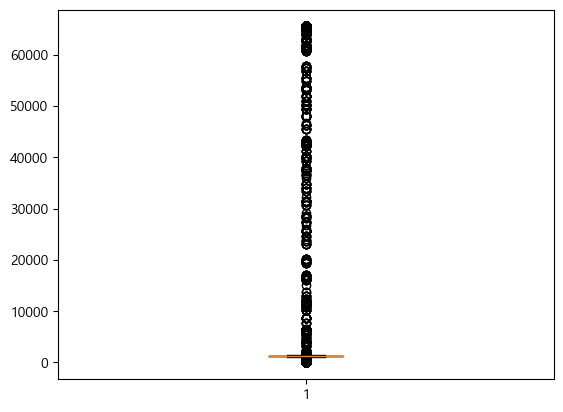

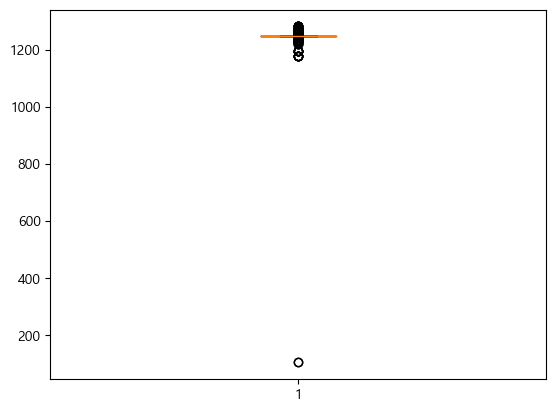

In [12]:

outlier_check(df_new.values)

count    52048.000000
mean      1312.974908
std       1315.057783
min          1.000000
25%       1226.000000
50%       1256.000000
75%       1288.000000
max      31441.000000
Name: Weight, dtype: float64



mean  1312.974907777436
usl: 5258.148255874837, lsl: -2632.198440319965




TimeStamp  Injection_Time  Filling_Time  \
0      2022-05-30 10:10:47+09:00            7.66          3.66   
1      2022-05-30 10:10:47+09:00            7.66          3.66   
2      2022-05-30 10:10:47+09:00            7.66          3.66   
3      2022-05-30 10:10:47+09:00            7.66          3.66   
4      2022-05-30 10:10:47+09:00            7.66          3.66   
...                          ...             ...           ...   
53348  2023-01-30 15:31:41+09:00            7.36          1.86   
53349  2023-01-30 15:32:35+09:00            7.36          1.86   
53350  2023-01-30 15:33:29+09:00            7.38          1.88   
53351  2023-01-30 15:34:23+09:00            7.36          1.86   
53352  2023-01-30 15:35:17+09:00            7.38          1.88   

       Plasticizing_Time  Cycle_Time  Clamp_Close_Time  Cushion_Position  \
0              25.150000   66.099998              4.57              21.6   
1              25.129999   66.099998              4.57              21.6   
2              25.180000   66.099998              4.57              21.5   
3              25.160000   66.099998              4.58              21.6   
4              25.160000   66.099998              4.56              21.6   
...                  ...         ...               ...               ...   
53348          11.590000   54.099998              4.44              15.0   
53349          11.570000   54.099998              4.44              15.0   
53350          11.570000   54.099998              4.44              15.1   
53351          11.570000   54.099998              4.44              15.1   
53352          11.580000   54.099998              4.44              15.0   

       Switch_Over_Position  Plasticizing_Position  Clamp_Open_Position  ...  \
0                      23.0             158.199997          1028.199951  ...   
1                      23.0             158.100006          1028.300049  ...   
2                      22.9             158.199997          1028.400024  ...   
3                      23.0             158.199997          1028.500000  ...   
4                      23.0             158.199997          1028.300049  ...   
...                     ...                    ...                  ...  ...   
53348                  16.0              84.699997           805.200012  ...   
53349                  16.0              84.800003           805.200012  ...   
53350                  16.0              84.699997           805.200012  ...   
53351                  16.0              84.699997           805.200012  ...   
53352                  16.0              84.599998           805.200012  ...   

       Hopper_SV  Product_CNT  Robot_Alarm  TakeOut_Time  TempCon_PV  \
0           80.0       1334.0         3333         11.95        50.0   
1           80.0       1334.0         3333         11.95        50.0   
2           80.0       1334.0         3333         11.95        50.0   
3           80.0       1334.0         3333         11.95        50.0   
4           80.0       1334.0         3333         11.95        50.0   
...          ...          ...          ...           ...         ...   
53348       80.0      27345.0         2222          7.79        61.9   
53349       80.0      27345.0         2222          7.79        61.9   
53350       80.0      27345.0         2222          7.79        61.9   
53351       80.0      27345.0         2222          7.79        61.9   
53352       80.0      27345.0         2222          7.79        61.9   

       TempCon_SV  Weight  Weight_Status  Workcd  anomal_detection  
0            50.0  1250.0           1111    HO25                 0  
1            50.0  1250.0           1111    HO25                 0  
2            50.0  1250.0           1111    HO25                 0  
3            50.0  1250.0           1111    HO25                 0  
4            50.0  1250.0           1111    HO25                 0  
...           ...     ...            ...     ...               ...  
53348   



[0 0 0 ... 0 0 0]


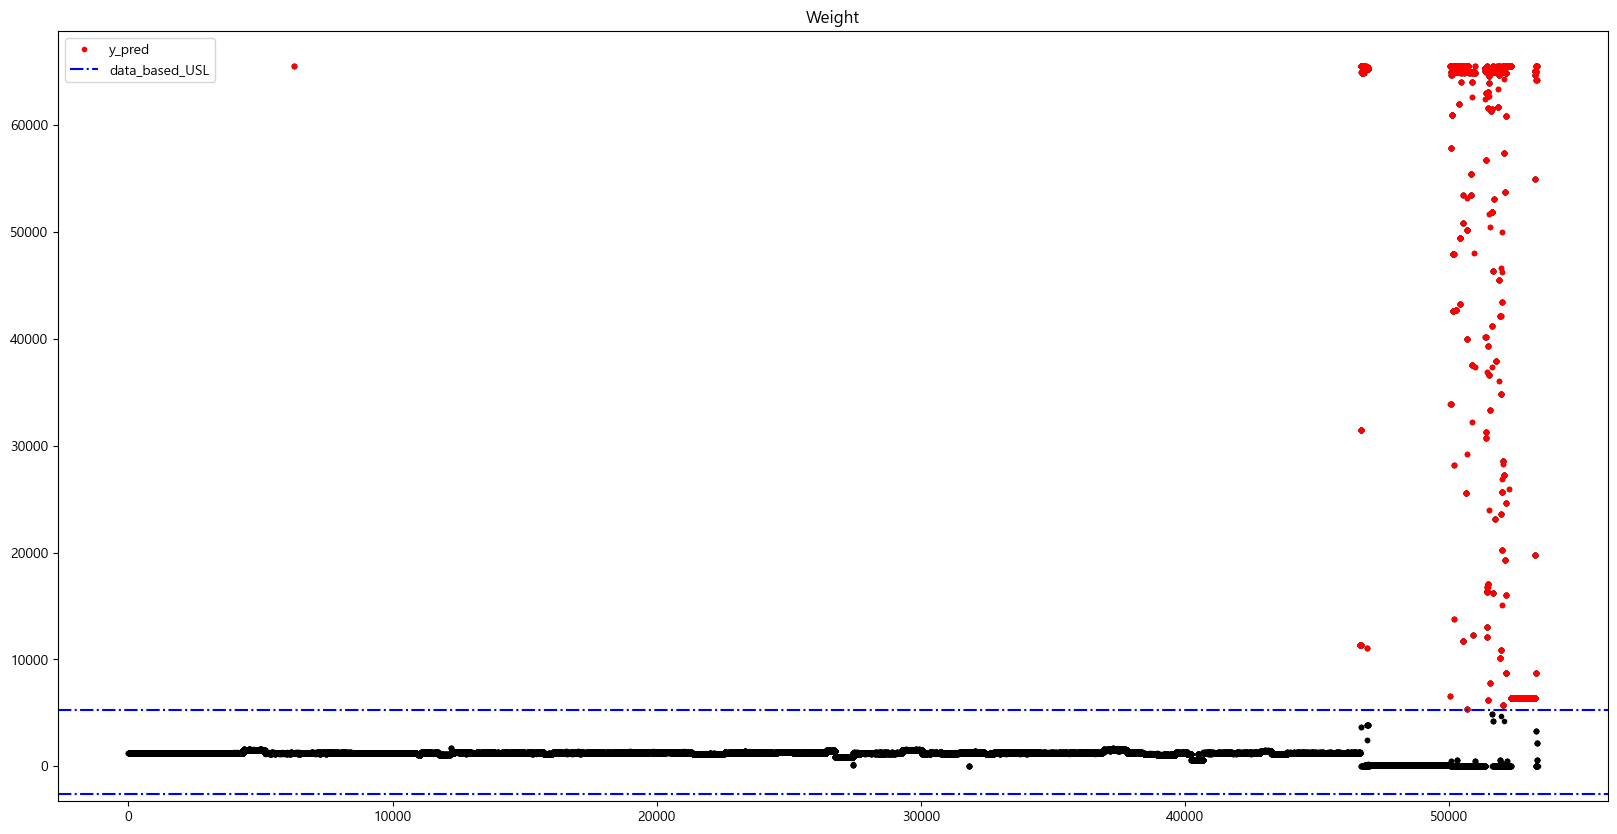

In [13]:
test_df = statistic_anomaly_detection(df_in=weight, process='Weight', upper_sig=3, under_sig=3)

## 이상탐지


In [39]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import rrcf

def run_isolation_forest(data, contamination=0.02, random_state=42):
    X = data

    X = X.reshape(-1,1)
    print(X.shape)

    # Isolation Forest 모델 생성
    clf = IsolationForest(contamination=contamination, random_state=random_state)

    # 모델 학습
    clf.fit(X)

    # 예측: 이상치인 경우 -1, 정상치인 경우 1 반환
    y_pred = clf.predict(X)

    normals = np.where(y_pred != -1)[0]
    anomaly = np.where(y_pred == -1)[0]

    y_pred[normals] = 0
    y_pred[anomaly] = 1

    # 결과 출력
    result = pd.DataFrame({process: data, 'Prediction': y_pred})
    
    return result


def run_dbscan(data, eps, min_samples):
    X = data

    X = X.reshape(-1,1)

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    y_pred = dbscan.fit_predict(X)

    normals = np.where(y_pred != -1)[0]
    anomaly = np.where(y_pred == -1)[0]

    y_pred[normals] = 0
    y_pred[anomaly] = 1
    result = pd.DataFrame({process: data, 'Prediction': y_pred})
    
    return result


def run_local_outlier_factor(data, contamination=0.5, neighbors=20):
    X = data

    X = X.reshape(-1,1)
    print(X.shape)

    # Isolation Forest 모델 생성
    clf = LocalOutlierFactor(n_neighbors=neighbors, contamination=contamination)

    # 모델 학습
    clf.fit(X)

    # 예측: 이상치인 경우 -1, 정상치인 경우 1 반환
    y_pred = clf.fit_predict(X)
    normals = np.where(y_pred != -1)[0]
    anomaly = np.where(y_pred == -1)[0]

    y_pred[normals] = 0
    y_pred[anomaly] = 1
    # 결과 출력
    result = pd.DataFrame({process: data, 'Prediction': y_pred})
    
    return result

def run_rrcf(data, num_trees = 100, tree_size = 256, threshold=150, shuffle= False):
    if shuffle:
        data = data.sample(frac=1)
        idx = data.index
        X = data.values
    else:
        idx = data.index
        X = data.values

    X = X.reshape(-1,1)
    n = X.shape[0]

    # Set forest parameters
    num_trees = num_trees
    tree_size = tree_size
    sample_size_range = (n // tree_size, tree_size)

    # Construct forest
    forest = []
    while len(forest) < num_trees:
        # Select random subsets of points uniformly
        ixs = np.random.choice(n, size=sample_size_range, replace=False)
        # Add sampled trees to forest
        trees = [rrcf.RCTree(X[ix], index_labels=ix) for ix in ixs]
        forest.extend(trees)

    # Compute average CoDisp
    avg_codisp = pd.Series(0.0, index=np.arange(n))
    index = np.zeros(n)
    for tree in forest:
        codisp = pd.Series({leaf : tree.codisp(leaf)
                        for leaf in tree.leaves})
        avg_codisp[codisp.index] += codisp
        np.add.at(index, codisp.index.values, 1)
    avg_codisp /= index
    threshold = avg_codisp.nlargest(n=threshold).min()
    anom_idx = avg_codisp[avg_codisp>threshold].index

    result = pd.DataFrame({process: data})
    result.reset_index(drop=False, inplace=True)
    result['Prediction'] = 0
    result.loc[anom_idx, 'Prediction'] = 1

    result.set_index(['index'], inplace=True)
    result.sort_index(inplace=True)
    return result


def modified_z_score(data, threshold=5):
    X = data.values
    
    X = X.reshape(-1,1)
    median = np.median(X)
    mad = np.median(np.abs(X - median))
    z_scores = 0.6745 * (X - median) / mad

    anom_idx = np.where(np.abs(z_scores) > threshold)[0]
    result = pd.DataFrame({process: data})

    result['Prediction'] = 0
    result.loc[anom_idx, 'Prediction'] = 1

    return result


def plot_result(result, model='IsolationForest'):
    anom_idx = result[(result['Prediction'] != 0)].index

    plt.figure(figsize=(20,10))
    plt.plot(result.loc[:,process], '.k')

    plt.plot(result.loc[anom_idx,process], '.r', label ='y_pred')

    plt.title(process + f" {model}")
    plt.legend()


In [37]:
eps = 2  # 이웃 포인트를 정의하는 반경의 크기
min_samples = 5  # 클러스터로 간주되기 위해 필요한 최소 포인트 수

result_dbscan = run_dbscan(test_df['Weight'].values, eps, min_samples)

In [23]:
result_zscore = modified_z_score(data=test_df['Weight'],threshold=15)

In [25]:
result_iso = run_isolation_forest(data=test_df['Weight'].values, contamination=0.04, random_state=42)

(53353, 1)


In [40]:
result_lof = run_local_outlier_factor(data=test_df['Weight'].values,contamination=0.09, neighbors=5)

(53353, 1)


In [27]:
result_rcf = run_rrcf(data=df_new,num_trees=100,tree_size=512, threshold=200, shuffle=False)

In [28]:
test_df['dbscan_pred'] = result_dbscan['Prediction']
test_df['iso_pred'] = result_iso['Prediction']
test_df['lof_pred'] = result_lof['Prediction']
test_df['rcf_pred'] = result_rcf['Prediction']
test_df['zscore_pred'] = result_zscore['Prediction']

In [29]:
print('Training set accuracy: ', accuracy_score(test_df['anomal_detection'], test_df['dbscan_pred']))
print('Test set accuracy: ',accuracy_score(test_df['anomal_detection'], test_df['dbscan_pred']))

print(classification_report(test_df['anomal_detection'], test_df['dbscan_pred']))

Training set accuracy:  0.9571532997207279
Test set accuracy:  0.9571532997207279
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     50951
           1       0.76      0.07      0.13      2402

    accuracy                           0.96     53353
   macro avg       0.86      0.53      0.55     53353
weighted avg       0.95      0.96      0.94     53353



In [30]:
print('Training set accuracy: ', accuracy_score(test_df['anomal_detection'], test_df['iso_pred']))
print('Test set accuracy: ',accuracy_score(test_df['anomal_detection'], test_df['iso_pred']))

print(classification_report(test_df['anomal_detection'], test_df['iso_pred']))

Training set accuracy:  0.9828688171236857
Test set accuracy:  0.9828688171236857
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     50951
           1       1.00      0.62      0.77      2402

    accuracy                           0.98     53353
   macro avg       0.99      0.81      0.88     53353
weighted avg       0.98      0.98      0.98     53353



In [31]:
print('Training set accuracy: ', accuracy_score(test_df['anomal_detection'], test_df['lof_pred']))
print('Test set accuracy: ',accuracy_score(test_df['anomal_detection'], test_df['lof_pred']))

print(classification_report(test_df['anomal_detection'], test_df['lof_pred']))

Training set accuracy:  0.9562723745618803
Test set accuracy:  0.9562723745618803
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     50951
           1       0.56      0.13      0.21      2402

    accuracy                           0.96     53353
   macro avg       0.76      0.56      0.59     53353
weighted avg       0.94      0.96      0.94     53353



In [32]:
print('Training set accuracy: ', accuracy_score(test_df['anomal_detection'], test_df['rcf_pred']))
print('Test set accuracy: ',accuracy_score(test_df['anomal_detection'], test_df['rcf_pred']))

print(classification_report(test_df['anomal_detection'], test_df['rcf_pred']))

Training set accuracy:  0.9555226510224355
Test set accuracy:  0.9555226510224355
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     50951
           1       0.57      0.05      0.09      2402

    accuracy                           0.96     53353
   macro avg       0.77      0.52      0.53     53353
weighted avg       0.94      0.96      0.94     53353



In [33]:
print('Training set accuracy: ', accuracy_score(test_df['anomal_detection'], test_df['zscore_pred']))
print('Test set accuracy: ',accuracy_score(test_df['anomal_detection'], test_df['zscore_pred']))

print(classification_report(test_df['anomal_detection'], test_df['zscore_pred']))

Training set accuracy:  0.9190298577399584
Test set accuracy:  0.9190298577399584
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     50951
           1       0.36      1.00      0.53      2402

    accuracy                           0.92     53353
   macro avg       0.68      0.96      0.74     53353
weighted avg       0.97      0.92      0.94     53353



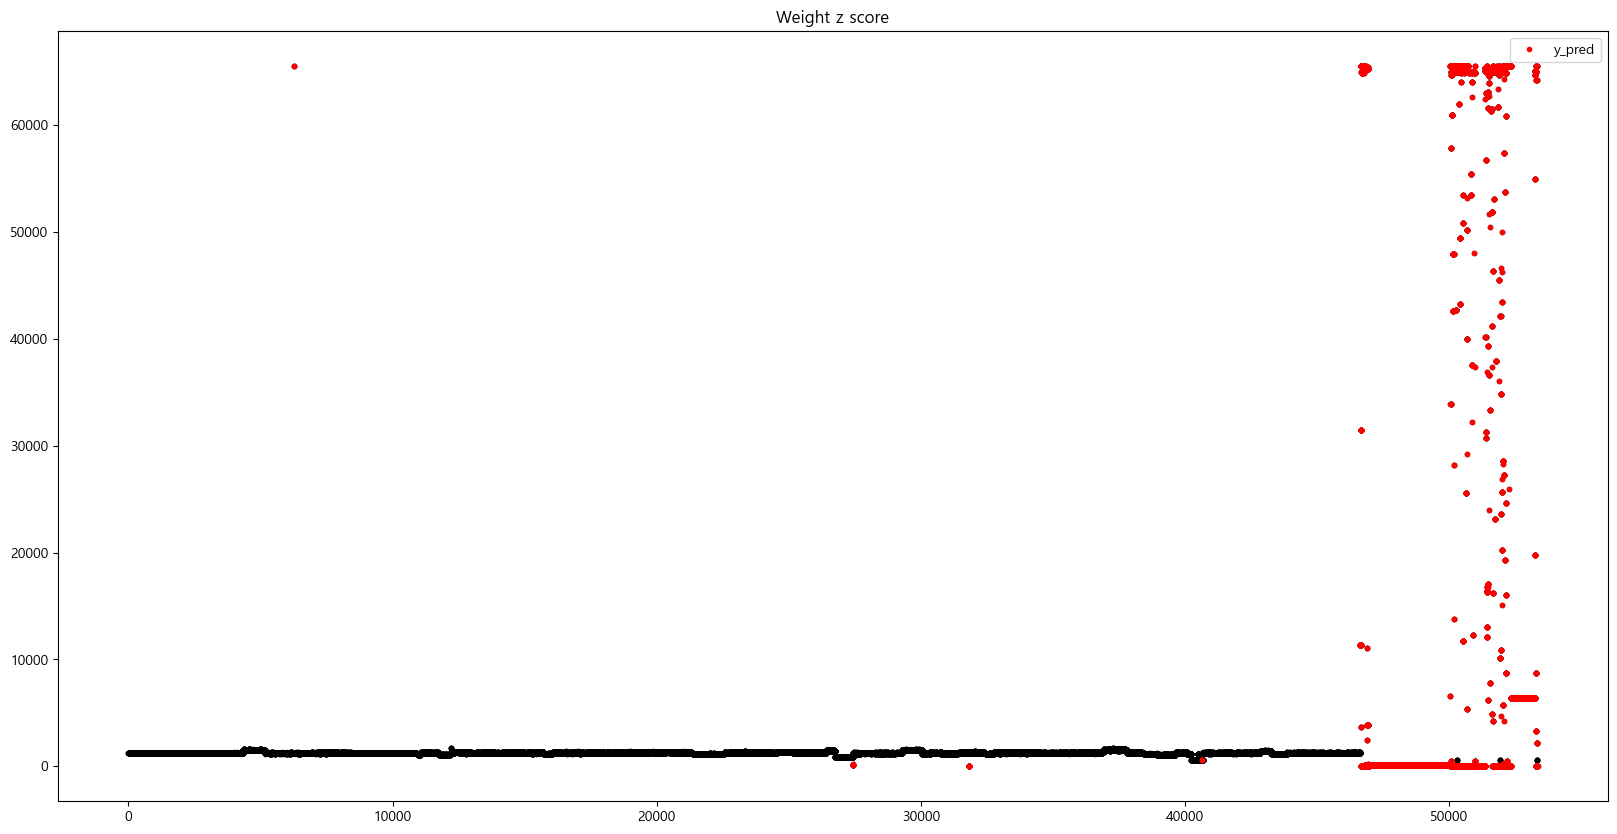

In [24]:
plot_result(result=result_zscore,model='z score')

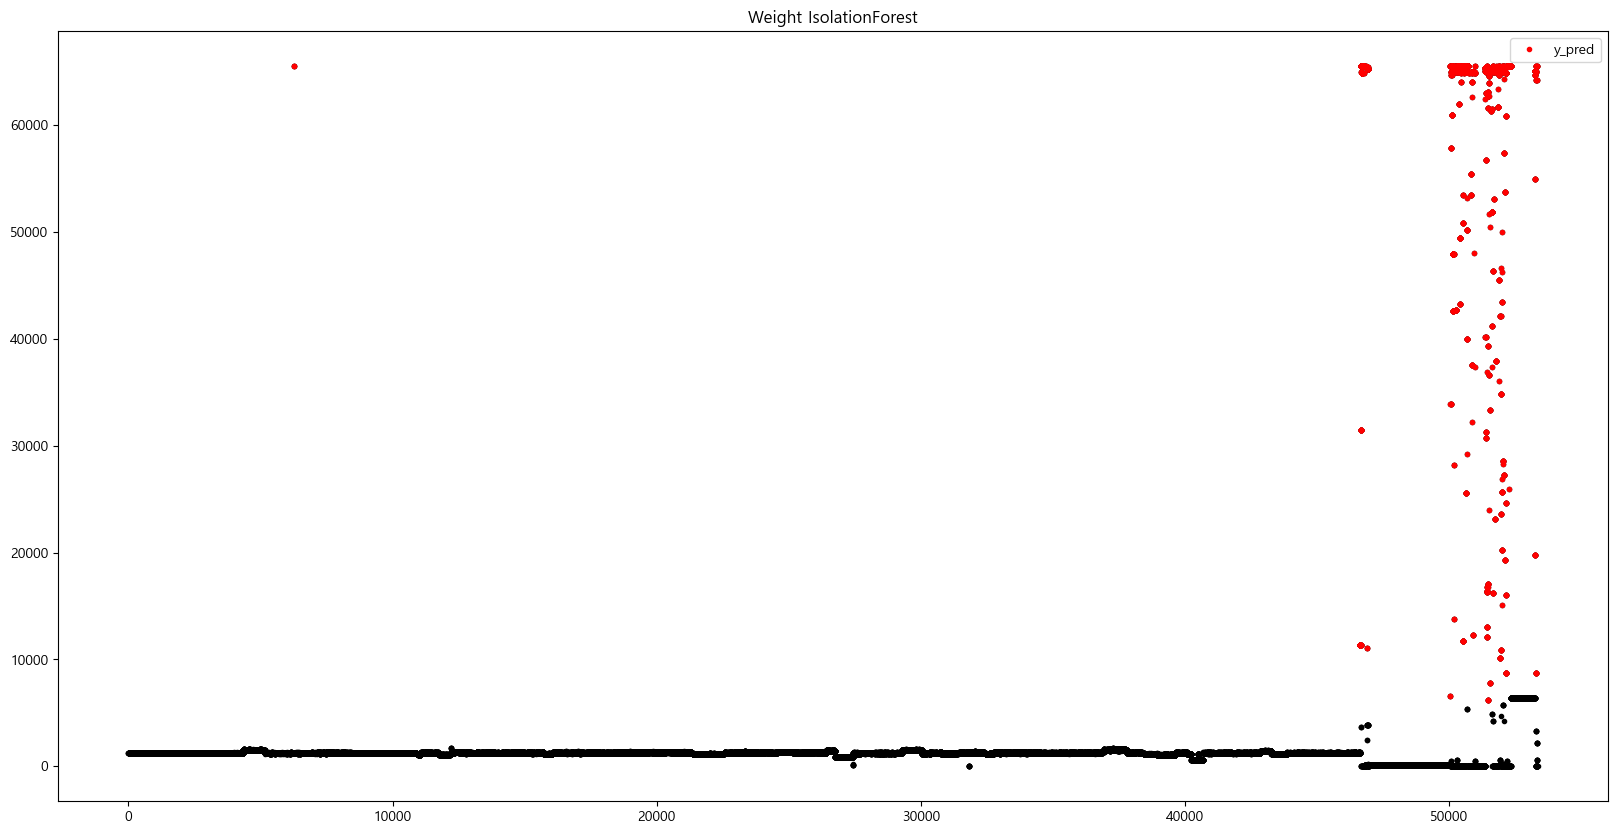

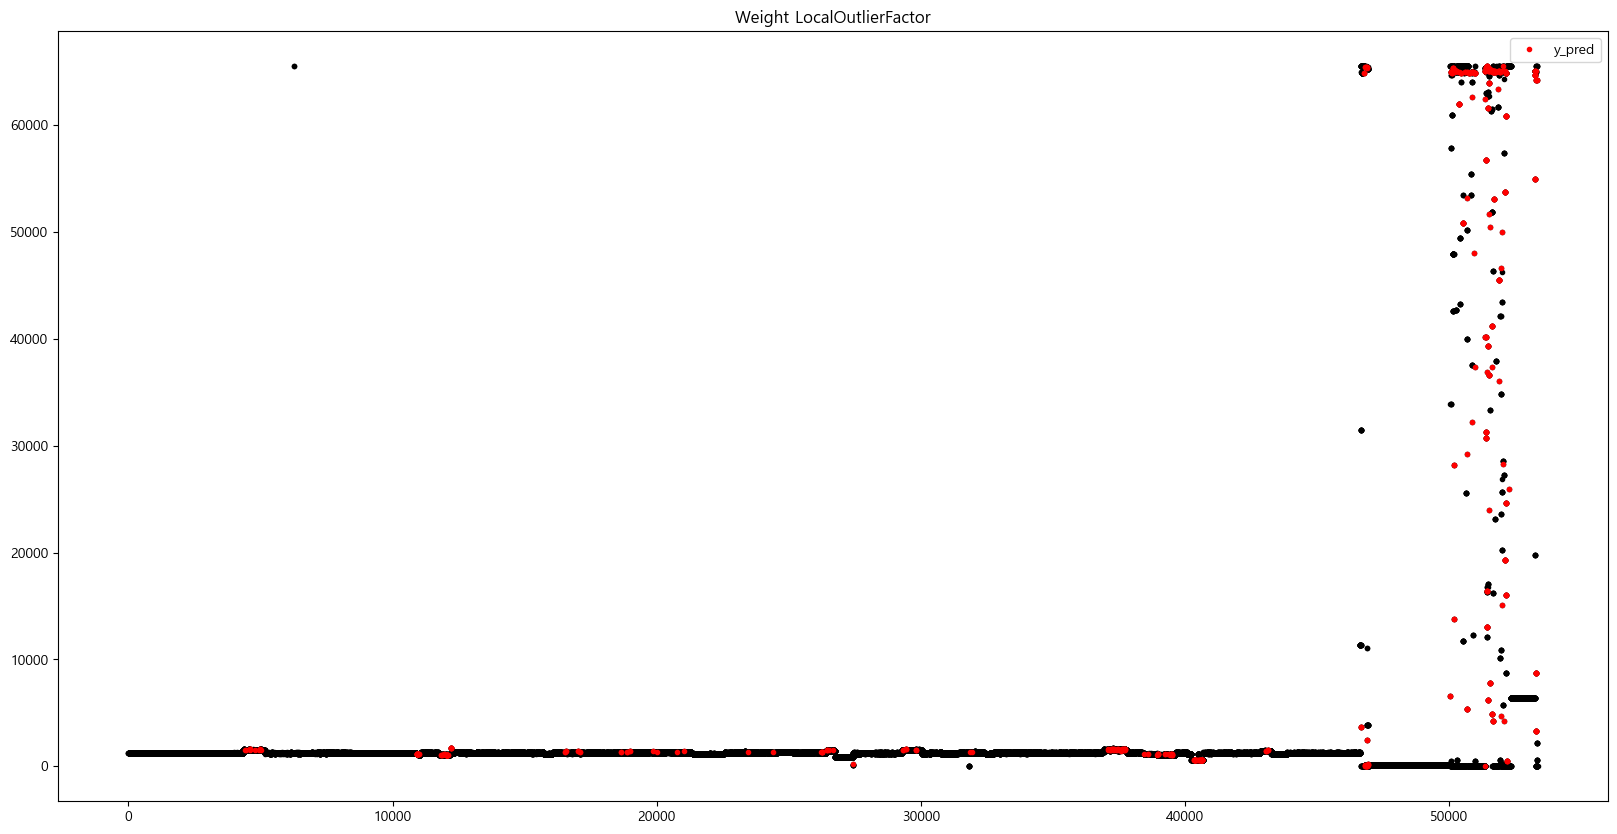

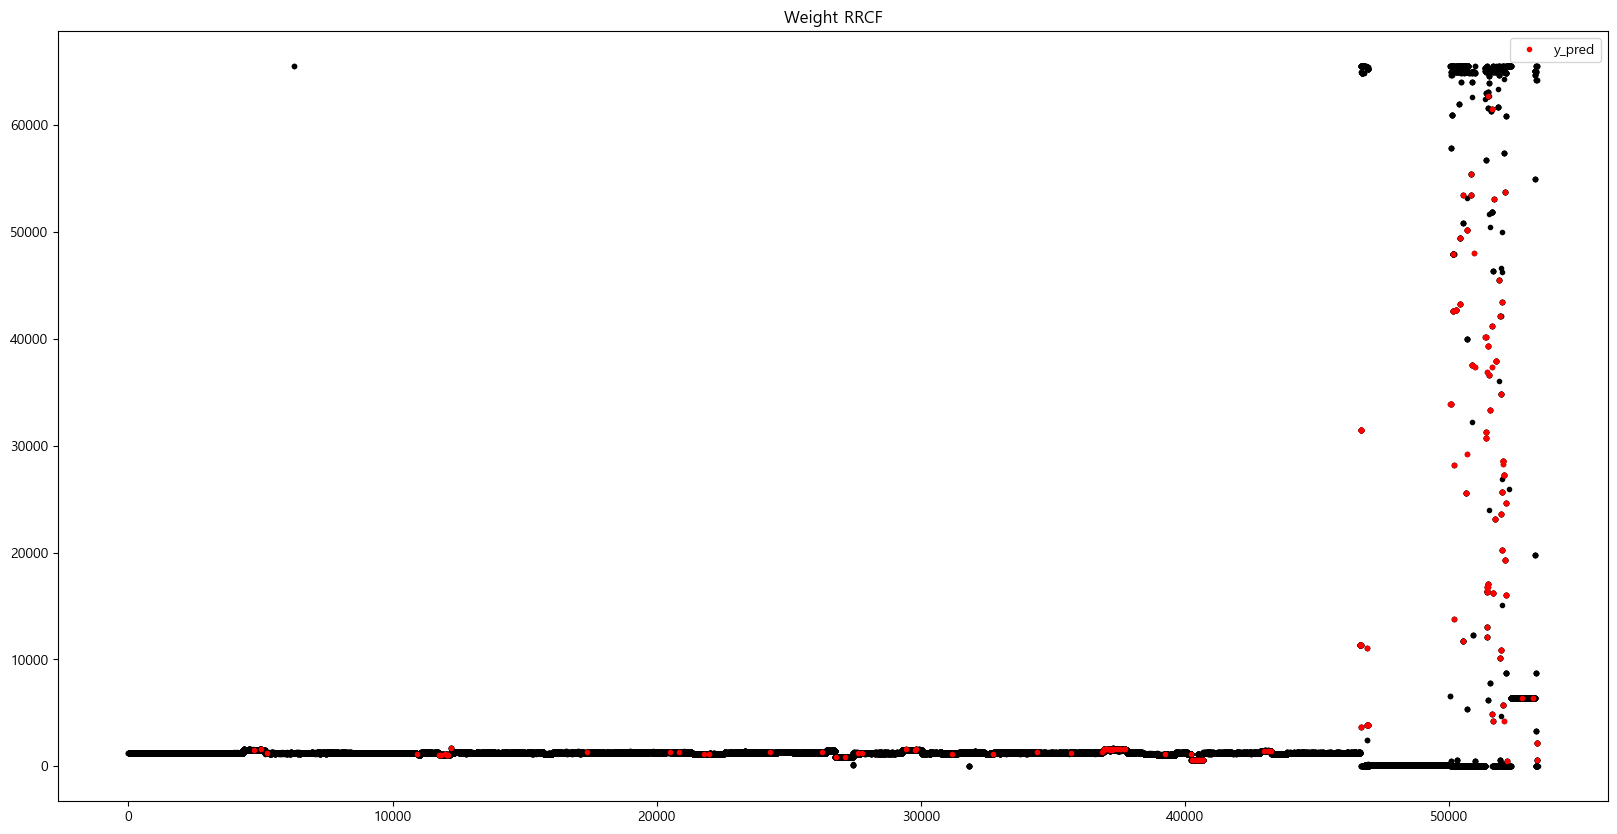

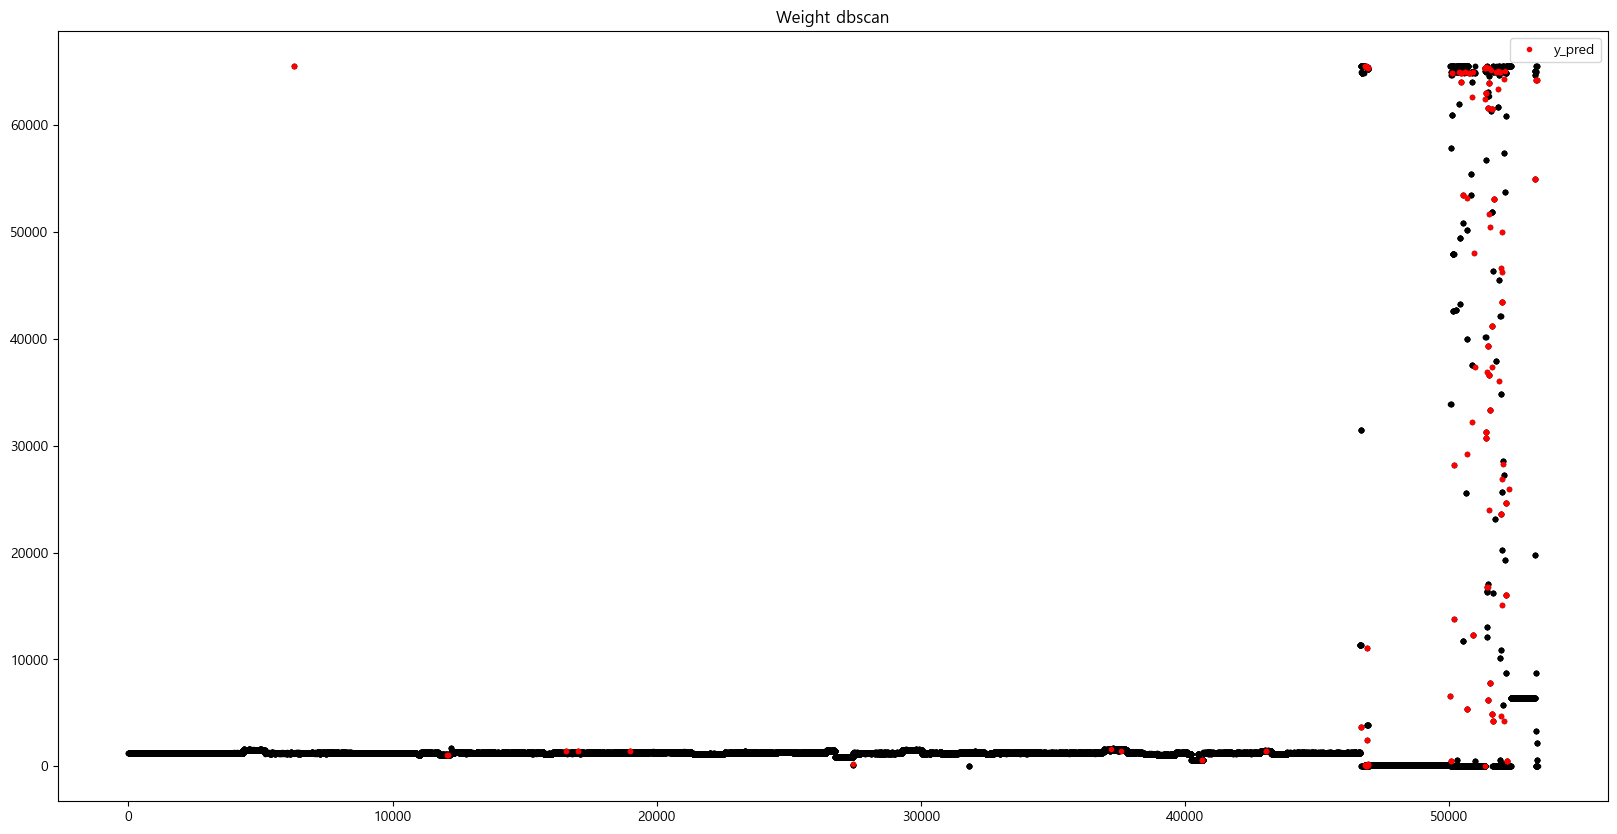

In [117]:
plot_result(result=result_iso)
plot_result(result=result_lof, model="LocalOutlierFactor")
plot_result(result=result_rcf, model="RRCF")
plot_result(result=result_dbscan,model = 'dbscan')

In [41]:
test_df

TimeStamp  Injection_Time  Filling_Time  \
0      2022-05-30 10:10:47+09:00            7.66          3.66   
1      2022-05-30 10:10:47+09:00            7.66          3.66   
2      2022-05-30 10:10:47+09:00            7.66          3.66   
3      2022-05-30 10:10:47+09:00            7.66          3.66   
4      2022-05-30 10:10:47+09:00            7.66          3.66   
...                          ...             ...           ...   
53348  2023-01-30 15:31:41+09:00            7.36          1.86   
53349  2023-01-30 15:32:35+09:00            7.36          1.86   
53350  2023-01-30 15:33:29+09:00            7.38          1.88   
53351  2023-01-30 15:34:23+09:00            7.36          1.86   
53352  2023-01-30 15:35:17+09:00            7.38          1.88   

       Plasticizing_Time  Cycle_Time  Clamp_Close_Time  Cushion_Position  \
0              25.150000   66.099998              4.57              21.6   
1              25.129999   66.099998              4.57              21.6   
2              25.180000   66.099998              4.57              21.5   
3              25.160000   66.099998              4.58              21.6   
4              25.160000   66.099998              4.56              21.6   
...                  ...         ...               ...               ...   
53348          11.590000   54.099998              4.44              15.0   
53349          11.570000   54.099998              4.44              15.0   
53350          11.570000   54.099998              4.44              15.1   
53351          11.570000   54.099998              4.44              15.1   
53352          11.580000   54.099998              4.44              15.0   

       Switch_Over_Position  Plasticizing_Position  Clamp_Open_Position  ...  \
0                      23.0             158.199997          1028.199951  ...   
1                      23.0             158.100006          1028.300049  ...   
2                      22.9             158.199997          1028.400024  ...   
3                      23.0             158.199997          1028.500000  ...   
4                      23.0             158.199997          1028.300049  ...   
...                     ...                    ...                  ...  ...   
53348                  16.0              84.699997           805.200012  ...   
53349                  16.0              84.800003           805.200012  ...   
53350                  16.0              84.699997           805.200012  ...   
53351                  16.0              84.699997           805.200012  ...   
53352                  16.0              84.599998           805.200012  ...   

       TempCon_SV  Weight  Weight_Status  Workcd  anomal_detection  \
0            50.0  1250.0           1111    HO25                 0   
1            50.0  1250.0           1111    HO25                 0   
2            50.0  1250.0           1111    HO25                 0   
3            50.0  1250.0           1111    HO25                 0   
4            50.0  1250.0           1111    HO25                 0   
...           ...     ...            ...     ...               ...   
53348        62.0     1.0           2222    HO25                 0   
53349        62.0     1.0           2222    HO25                 0   
53350        62.0     1.0           2222    HO25                 0   
53351        62.0     1.0           2222    HO25                 0   
53352        62.0     1.0           2222    HO25                 0   

       dbscan_pred  iso_pred  lof_pred  rcf_pred  zscore_pred  
0                0         0         0         0            0  
1                0         0         0         0            0  
2                0         0         0         0            0  
3                0         0         0         0            0  
4                0         0         0         0            0  
...            ...       ...       ...       ...          ...  
53348            0         0         0         0            1  
533

# Ensemble

In [43]:
results_list = [result_dbscan['Prediction'].values, result_iso['Prediction'].values, result_lof['Prediction'].values, result_rcf['Prediction'].values, result_zscore['Prediction'].values]

In [44]:
from statistics import mode


# Hard Voting 
def hard_voting(predictions : list) -> np.array:
    return [mode(v) for v in np.array(predictions).T]


hv_predictions = hard_voting(results_list)

In [47]:
test_df['ensemble_pred'] = hv_predictions

In [48]:
print('Training set accuracy: ', accuracy_score(test_df['anomal_detection'], test_df['ensemble_pred']))
print('Test set accuracy: ',accuracy_score(test_df['anomal_detection'], test_df['ensemble_pred']))

print(classification_report(test_df['anomal_detection'], test_df['ensemble_pred']))

Training set accuracy:  0.9624950799392724
Test set accuracy:  0.9624950799392724
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     50951
           1       0.92      0.18      0.30      2402

    accuracy                           0.96     53353
   macro avg       0.94      0.59      0.64     53353
weighted avg       0.96      0.96      0.95     53353

